Evaluation for TCGA-KIRC for survival analysis, including with novel clinical data

In [4]:
# Imports
from core.utils_data import getCleanGBMLGG
import pandas as pd
import numpy as np
from tqdm import tqdm
from core.utils_analysis_new import *
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from lifelines import KaplanMeierFitter
import pickle
from scipy.stats import zscore
import os

# Define relevant dirs
checkpoints_dir = './checkpoints/TCGA_KIRC'
eval_folder = 'evaluation'
results = 'results'
plt.rc('text', usetex=True)

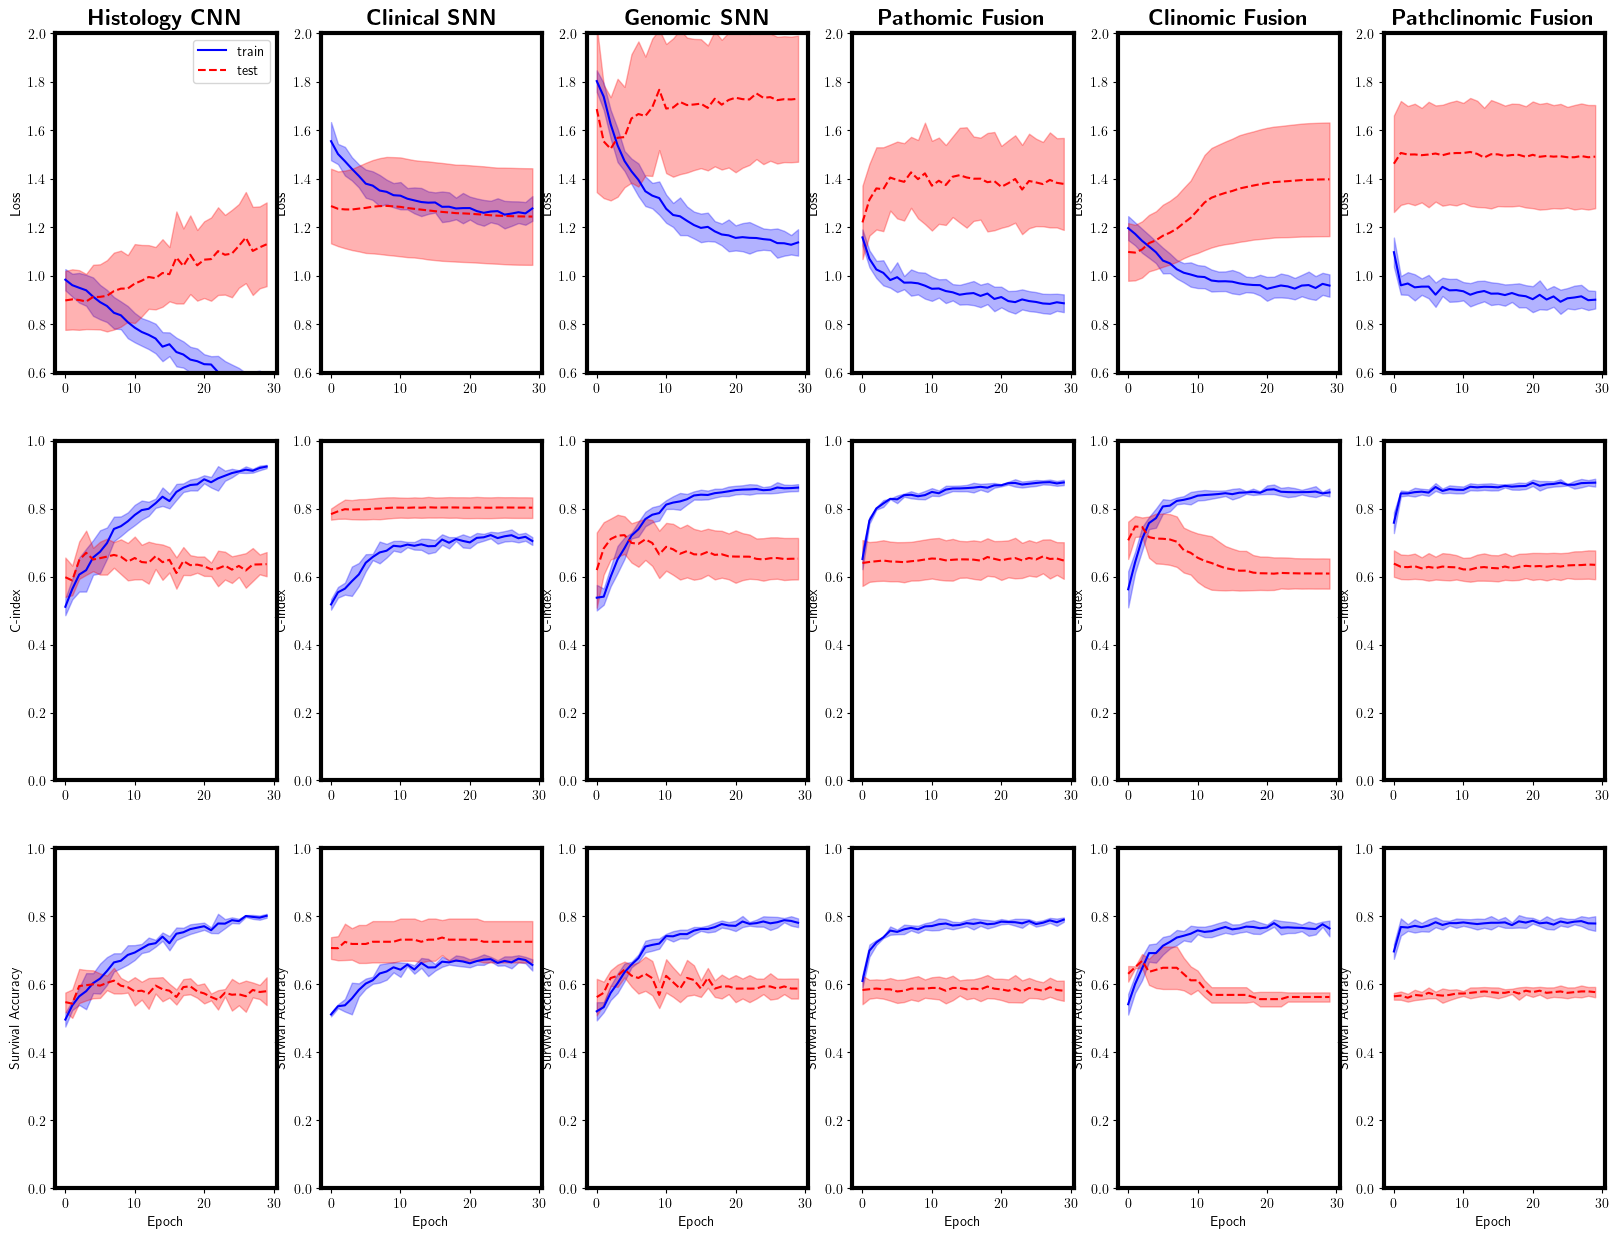

In [6]:
#### LOSS & METRIC PLOTS - SURVIVAL ####
# List of model names
model_names = ['path', 'clin', 'omic', 'pathomic_fusion', 'clinomic_fusion',  'pathclinomic_fusion']

# Define relabeling dictionaries
model_mappings = {
    'omic': 'Genomic SNN',
    'path': 'Histology CNN',
    'clin': 'Clinical SNN',
    'pathomic_fusion': 'Pathomic Fusion',
    'clinomic_fusion': 'Clinomic Fusion',
    'pathclinomic_fusion': 'Pathclinomic Fusion',
    'omicomic_fusion': 'Omicomic Fusion', 
    'pathpath_fusion': 'Pathpath Fusion',  
    'clinclin_fusion': 'Graphgraph Fusion'  
}
metric_mapping = {
    'loss': 'Loss',
    'cindex': 'C-index',
    'surv_acc': 'Survival Accuracy'
}

metrics = ['loss', 'cindex', 'surv_acc']
exp_name = 'surv_15'
num_cols = len(model_names)
num_rows = 3 
exp_name = 'surv_15'
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Define colors for training and testing metrics
train_color = 'blue'
test_color = 'red'

for metric_index, metric in enumerate(metrics):
    for i, model_name in enumerate(model_names):
        all_train_metrics = []
        all_test_metrics = []

        for k in range(1, 5):
            results_dir = os.path.join(checkpoints_dir, exp_name, results)
            csv_filepath = os.path.join(results_dir, f'{model_name}_metrics_{k}.csv')
            df = pd.read_csv(csv_filepath)

            train_metric = df[f'train_{metric}']
            test_metric = df[f'test_{metric}']

            all_train_metrics.append(train_metric)
            all_test_metrics.append(test_metric)

        # Calculate mean and std
        train_mean = np.mean(all_train_metrics, axis=0)
        train_std = np.std(all_train_metrics, axis=0)
        test_mean = np.mean(all_test_metrics, axis=0)
        test_std = np.std(all_test_metrics, axis=0)

        row = metric_index
        col = i

        ax = axes[row, col]
        epochs = range(len(train_mean))

        ax.plot(epochs, train_mean, label='train', color=train_color)
        ax.fill_between(epochs, train_mean - train_std, train_mean + train_std, color=train_color, alpha=0.3)

        ax.plot(epochs, test_mean, label='test', linestyle='--', color=test_color)
        ax.fill_between(epochs, test_mean - test_std, test_mean + test_std, color=test_color, alpha=0.3)

        if row == 0:
            ax.set_title(rf'$\textbf{{{model_mappings.get(model_name, model_name)}}}$', fontsize=16)
        if row == num_rows - 1:
            ax.set_xlabel('Epoch')
        ax.set_ylabel(metric_mapping.get(metric, metric))
        if col == 0 and metric_index == 0:
            ax.legend()
        if metric == 'loss':
            ax.set_ylim(0.6, 2)  
        elif metric == 'surv_acc':
            ax.set_ylim(0, 1) 
        else:
            ax.set_ylim(0, 1)  

# Create the directory if it does not exist
os.makedirs(os.path.join(checkpoints_dir, eval_folder), exist_ok=True)

# Save the plot
plot_filepath = os.path.join(checkpoints_dir, eval_folder, f'kirc_surv_losses.png')
plt.savefig(plot_filepath)
plt.show()
plt.close()

In [15]:
#### Summary table of c-indices for TCGA-KIRC ####
# Define relabeling dictionaries
model_mappings = {
    'graph': 'Graph GCN',
    'path': 'Histology CNN',
    'omic': 'Genomic SNN',
    'pathomic_fusion': 'Pathomic Fusion (CNN+SNN)',
    'graphomic_fusion': 'Graphomic Fusion (GCN+SNN)',
    'pathgraphomic_fusion': 'Pathgraphomic Fusion (CNN+GCN+SNN)',
    'pathgraph_fusion': 'Pathgraph Fusion (CNN+GCN)',
    'omicomic_fusion': 'Omicomic Fusion (SNN+SNN)', 
    'pathpath_fusion': 'Pathpath Fusion (CNN+CNN)',  
    'graphgraph_fusion': 'Graphgraph Fusion (GCN+GCN)'  
}
# List of model names
model_names = ['path', 'clin', 'omic', 'pathomic_fusion', 'clinomic_fusion',  'pathclinomic_fusion']

# Initialize list to store metrics
metrics_list = []

# Extract metrics for each model
for model in model_names:
    results_loc = os.path.join(checkpoints_dir, 'surv_15', model, f'{model}_results.pkl')
    with open(results_loc, 'rb') as f:
        results = pickle.load(f)
        metrics_list.append({
            "Model": model,
            "Mean C-index": np.mean(results),
            "Standard Deviation": np.std(results)
        })

summary_df = pd.DataFrame(metrics_list)
print(summary_df)

                 Model  Mean C-index  Standard Deviation
0                 path      0.620536            0.027413
1                 clin      0.802990            0.030280
2                 omic      0.652888            0.061092
3      pathomic_fusion      0.648174            0.053488
4      clinomic_fusion      0.609105            0.044369
5  pathclinomic_fusion      0.634705            0.041995


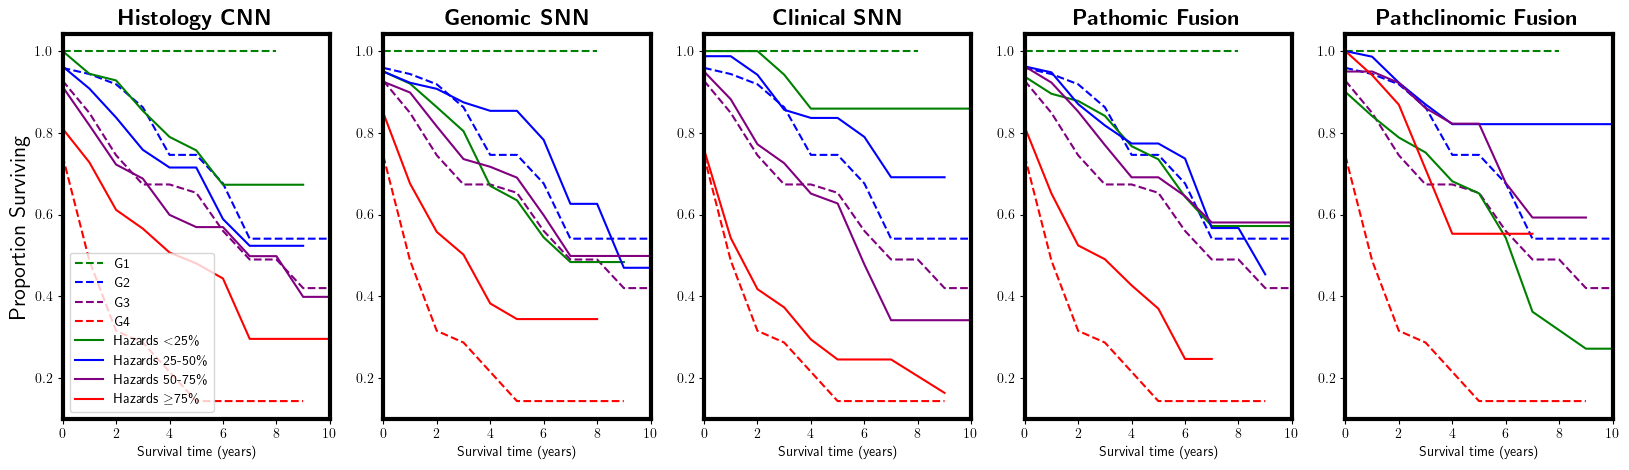

In [16]:
#### Kaplan- Meier Curves by Fuhrman grade and 25/50/75/100% hazards ####
model_names = ['path', 'clin', 'omic', 'pathomic_fusion', 'clinomic_fusion',  'pathclinomic_fusion']

# Define relabeling dictionaries
model_mappings = {
    'omic': 'Genomic SNN',
    'path': 'Histology CNN',
    'clin': 'Clinical SNN',
    'pathomic_fusion': 'Pathomic Fusion',
    'clinomic_fusion': 'Clinomic Fusion',
    'pathclinomic_fusion': 'Pathclinomic Fusion',
    'omicomic_fusion': 'Omicomic Fusion', 
    'pathpath_fusion': 'Pathpath Fusion',  
    'clinclin_fusion': 'Graphgraph Fusion'  
}

split = 'test'
use_patch = '_'
ckpt_name = './checkpoints/TCGA_KIRC/surv_15'

fig, axs = plt.subplots(1, 5, figsize=(20, 5))


grade_mappings = {
    '0': 'G1',
    '1': 'G2',
    '2': 'G3',
    '3': 'G4',
}

grade_mappings_pred = {
    '0': r'Hazards $<$25\%',
    '1': r'Hazards 25-50\%',
    '2': r'Hazards 50-75\%',
    '3': r'Hazards $\geq$75\%',
}

# Aggregate the survival data
for j, model in enumerate(['path', 'omic', 'clin', 'pathomic_fusion', 'pathclinomic_fusion']):
    data_saver= []
    for k in range(1,5):
        data = load_and_process_survival_kirc_data(model, k, split)
        data_saver.append(data)
    data = pd.concat(data_saver, ignore_index=True)
    df = pd.read_csv('./data/TCGA_KIRC/kirc_tcga_pan_can_atlas_2018_clinical_data.tsv', sep='\t')
    data = data.merge(df, on='Patient ID', how='left') 
    model_name = model_mappings.get(model, 'Unknown Model')
  
    # Grade status information
    mapping = {'G1': 0, 'G2': 1, 'G3': 2, 'G4': 3}
    grade_status = data['Neoplasm Histologic Grade'].map(mapping)

    hazards = data['Hazards']
    censor_status = data['Censor Status']
    survival_times = data['Survival Time']
    survival_times = survival_times // 12

    # Kaplan-Meier curve by grade status
    kmf = KaplanMeierFitter()

    # Threshold probabilities
    thresholds = [25, 50, 75, 100]
    percentiles_of_hazards = np.percentile(hazards, thresholds)
    # Assign grades to hazard values based on percentiles
    grade_status_predicted = np.array([hazard2grade(h, percentiles_of_hazards) for h in hazards])

    # Plot the Kaplan-Meier curves
    colours = ['green', 'blue', 'purple', 'red']
    colours2 = ['green', 'blue', 'red', 'purple']
    colours3 = ['green', 'blue', 'red', 'purple']

    for grade, color in zip([0, 1, 2, 3], colours):
        mask = (grade_status == grade)
        grade_map = grade_mappings.get(str(grade))
        kmf.fit(durations=survival_times[mask], event_observed=censor_status[mask])
        kmf.survival_function_
        axs[j].plot(kmf.survival_function_, linestyle="--", color=color, label=f'{grade_map}')
        if j == 0:
            axs[j].set_ylabel('Proportion Surviving', fontsize=16)

    for grade, color in zip([0, 1, 2, 3], colours):
        if grade ==3:
            grade = 3 or 4
        mask = (grade_status_predicted == grade)
        grade_map_pred = grade_mappings_pred.get(str(grade))
        kmf.fit(durations=survival_times[mask], event_observed=censor_status[mask])
        kmf.survival_function_
        axs[j].plot(kmf.survival_function_, linestyle="-", color=color, label=f'{grade_map_pred}')
        axs[j].set_xlim([0, 10])
        axs[j].set_title(rf'$\textbf{{{model_mappings.get(model_name, model_name)}}}$', fontsize=16)
        if j==0:
            axs[j].legend()
    axs[j].set_xlabel('Survival time (years)')

os.makedirs(os.path.join(ckpt_name, eval_folder), exist_ok=True)
plot_filepath = os.path.join(ckpt_name, eval_folder, f'kaplan_meier_kirc.png')
plt.savefig(plot_filepath)
plt.show()
plt.close()

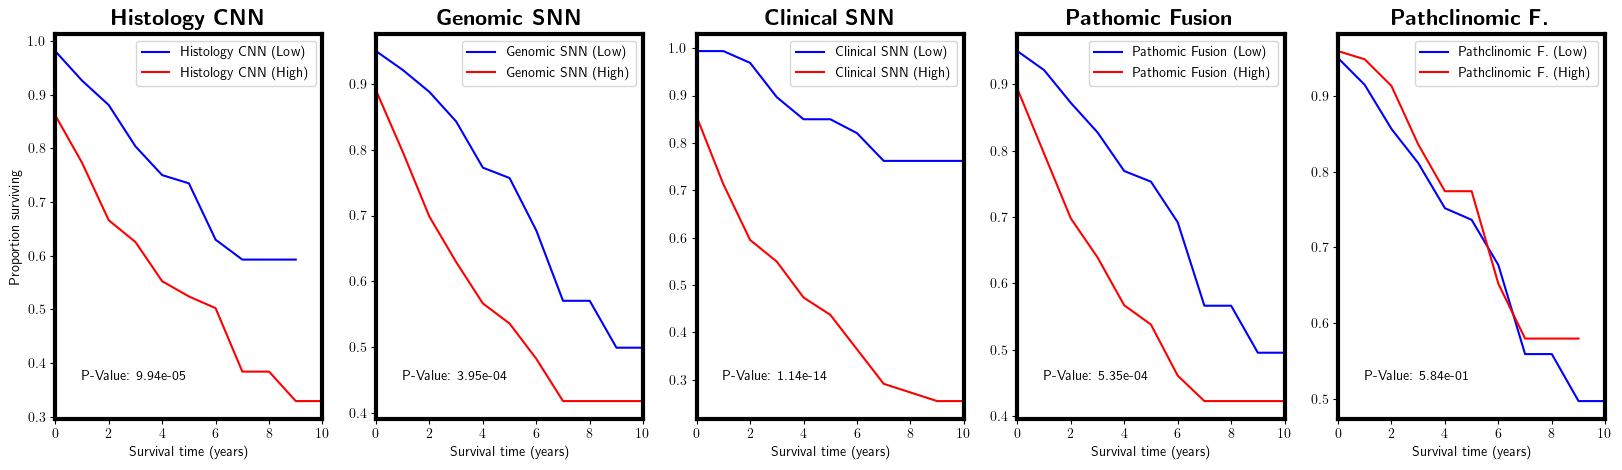

In [17]:
#### Kaplan- Meier Curves by survival status and 50/100% hazards ####
model_names = ['path', 'clin', 'omic', 'pathomic_fusion', 'clinomic_fusion',  'pathclinomic_fusion']

# Define relabeling dictionaries
model_mappings = {
    'omic': 'Genomic SNN',
    'path': 'Histology CNN',
    'clin': 'Clinical SNN',
    'pathomic_fusion': 'Pathomic Fusion',
    'clinomic_fusion': 'Clinomic Fusion',
    'pathclinomic_fusion': 'Pathclinomic F.',
    'omicomic_fusion': 'Omicomic Fusion', 
    'pathpath_fusion': 'Pathpath Fusion',  
    'clinclin_fusion': 'Graphgraph Fusion'  
}

grade_mappings = {
    '0': '(Low)',
    '1': '(High)',
}
split = 'test'
use_patch = '_'
ckpt_name = './checkpoints/TCGA_KIRC/surv_15'

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Aggregate the survival data
for j, model in enumerate(['path', 'omic', 'clin', 'pathomic_fusion', 'pathclinomic_fusion']):
    data_saver= []
    for k in range(1,5):
        data = load_and_process_survival_kirc_data(model, k, split)
        data_saver.append(data)
    data = pd.concat(data_saver, ignore_index=True)
    df = pd.read_csv('./data/TCGA_KIRC/kirc_tcga_pan_can_atlas_2018_clinical_data.tsv', sep='\t')
    data = data.merge(df, on='Patient ID', how='left') 
    model_name = model_mappings.get(model, 'Unknown Model')
  
    # Grade status information
    mapping = {'G1': 0, 'G2': 1, 'G3': 2, 'G4': 3}
    grade_status = data['Neoplasm Histologic Grade'].map(mapping)
    hazards = data['Hazards']
    censor_status = data['Censor Status']
    survival_times = data['Survival Time']
    survival_times = survival_times // 12

    # Kaplan-Meier curve by grade status
    kmf = KaplanMeierFitter()

    thresholds = [50, 100]
    percentiles_of_hazards = np.percentile(hazards, thresholds)
    # Assign grades to hazard values based on percentiles
    grade_status_predicted = np.array([hazard2grade(h, percentiles_of_hazards) for h in hazards])

    # Plot the Kaplan-Meier curves
    colours = ['blue', 'red']

    for grade, color in zip([0, 1], colours):
        mask = (grade_status_predicted == grade)
        kmf.fit(durations=survival_times[mask], event_observed=censor_status[mask])
        grade_maps = grade_mappings.get(str(grade))
        kmf.survival_function_
        axs[j].plot(kmf.survival_function_, linestyle="-", color=color, label=f'{model_name} {grade_maps}')
        axs[j].set_xlim([0, 10])
        axs[j].set_title(rf'$\textbf{{{model_mappings.get(model_name, model_name)}}}$', fontsize=16)
        if j == 0:
            axs[j].set_ylabel('Proportion surviving')
        axs[j].legend()
    axs[j].set_xlabel('Survival time (years)')

        
    # Log-rank test and p-value annotation
    results = logrank_test(survival_times[grade_status_predicted == 0], survival_times[grade_status_predicted == 1],
                           event_observed_A=censor_status[grade_status_predicted == 0], 
                           event_observed_B=censor_status[grade_status_predicted == 1])
    p_value = results.p_value
    axs[j].text(0.1, 0.1, f'P-Value: {p_value:.2e}', transform=axs[j].transAxes)

plot_filepath = os.path.join(ckpt_name, eval_folder, f'kaplan_meier_kirc_50.png')
plt.savefig(plot_filepath)
plt.show()
plt.close()

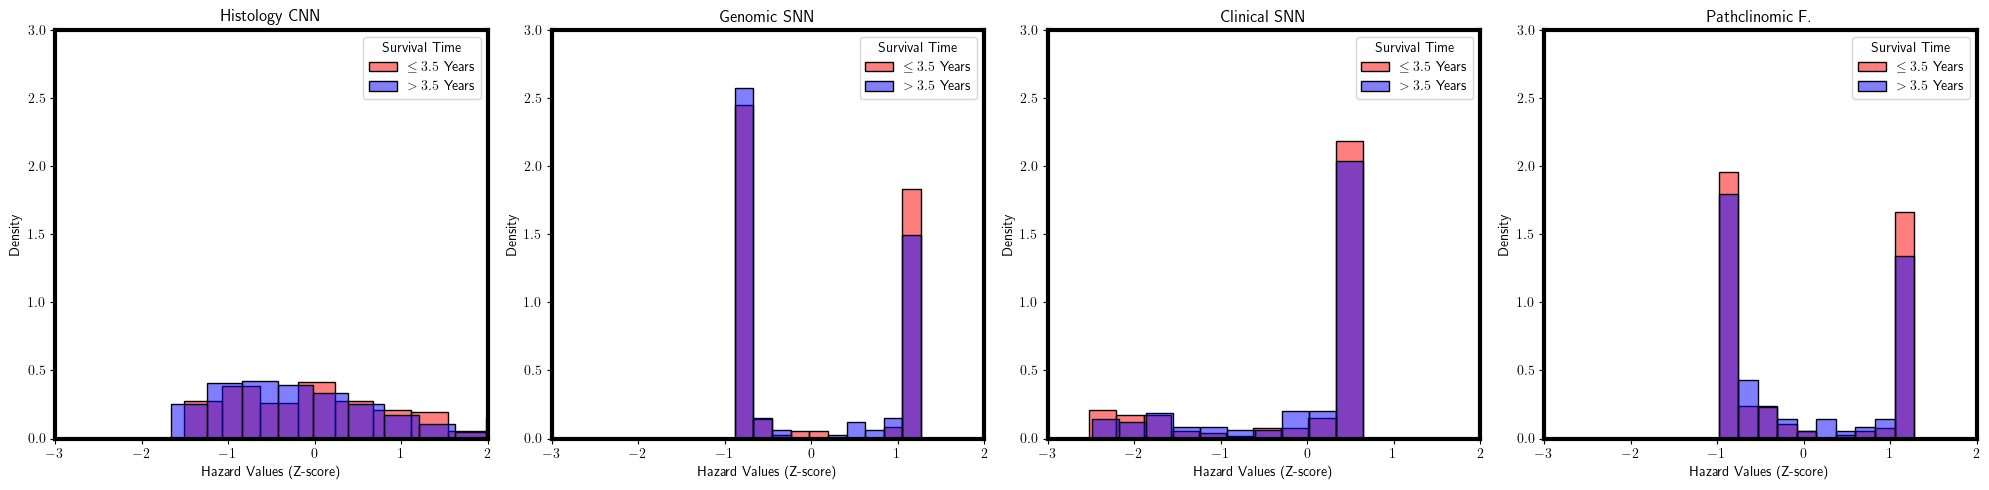

In [21]:
### HISTOGRAM HAZARD PLOTS for different models ###
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  
for j, model in enumerate(['path', 'omic', 'clin', 'pathclinomic_fusion']):
    data_saver= []
    for k in range(1,5):
        data = load_and_process_survival_kirc_data(model, k, split)
        data_saver.append(data)
    data = pd.concat(data_saver, ignore_index=True)
    ax = axes[j]
    model_name = model_mappings.get(model, 'Unknown Model') 
    ## Z-scored hazards histograms
    # Calculate the z-scores of the 'Hazards'
    data['Hazards_z'] = zscore(data['Hazards'])

    # Split the data based on the survival time with low and high being thresholded by 5 years
    low = data[data['Survival Time'] <= 12*3.5]
    high = data[data['Survival Time'] > 12*3.5]

    # Histogram plotting with normalized density using plt directly
    sns.histplot(low['Hazards_z'], ax=ax,bins=10, kde=False, stat="density", color="red", alpha=0.5, edgecolor="black", label=r'$\leq 3.5$ Years')
    sns.histplot(high['Hazards_z'], ax=ax, bins=10,kde=False, stat="density",color="blue", alpha=0.5, edgecolor="black", label=r'$> 3.5$ Years')

    # Adjusting the visual layout of the plot
    ax.set_xlabel('Hazard Values (Z-score)')
    ax.set_ylabel('Density')
    ax.set_xlim([-3, 2])
    ax.set_ylim([0, 3])

    # Title for each subplot
    ax.set_title(f'{model_name}')

    # Adding legend to each subplot
    ax.legend(title="Survival Time")

# Adjust layout to prevent overlapping
plt.tight_layout()   
plt.show()
